In [29]:
import pandas as pd 
import numpy as np 
from dune_client.client import DuneClient
import matplotlib.pyplot as plt
import warnings
import requests
import json
import os

plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

In [30]:
dune = DuneClient("GoqSBIhlgih0Tfyagilyoqerh0AZi4cv")
query_result = dune.get_latest_result(6308595)

In [45]:
def get_latest_query_result(query_id: int, api_key: str) -> pd.DataFrame:
    res_df = pd.DataFrame()
    result_url = f"https://api.dune.com/api/v1/query/{query_id}/results"
    headers = {"x-dune-api-key": api_key}
    
    try:
        response = requests.get(result_url, headers=headers)
        
        if response.status_code == 200:
            data = response.json()
            rows = data["result"]["rows"]
            res_df = pd.DataFrame.from_dict(rows)
        else:
            print(f"Error {response.status_code}: {response.text}")
            
    except Exception as e:
        print(f"Exception: {e}")

    res_df.time = pd.to_datetime(res_df.time)
    res_df['basis_pct'] = (res_df.steth_price / res_df.eth_price - 1) * 100
        
    return res_df.set_index('time').sort_index(ascending=True).dropna()

api_key = "GoqSBIhlgih0Tfyagilyoqerh0AZi4cv" 
query_id = 6308595

df = get_latest_query_result(query_id, api_key)
df.head()

,basis_ratio,eth_price,steth_price,basis_pct
time,,,,
2021-08-26 00:00:00+00:00,0.988135,3118.744444,3081.740625,-1.186497
2021-08-27 00:00:00+00:00,0.987336,3159.680000,3119.665382,-1.266414
2021-08-28 00:00:00+00:00,0.973374,3238.580451,3152.351042,-2.662568
2021-08-29 00:00:00+00:00,0.957201,3252.177813,3112.989028,-4.279864
2021-08-30 00:00:00+00:00,0.950042,3230.866528,3069.460208,-4.995759


<Axes: title={'center': 'stETH/ETH Ratio Basis'}, xlabel='Dates', ylabel='Basis Ratio'>

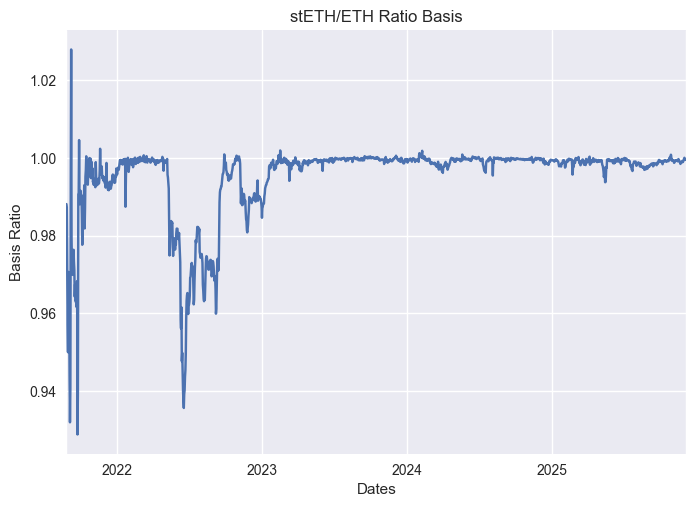

In [46]:
df['basis_ratio'].plot(xlabel='Dates', ylabel='Basis Ratio', title='stETH/ETH Ratio Basis')

<Axes: title={'center': 'stETH/ETH Percentage Basis'}, xlabel='Dates', ylabel='Basis (%)'>

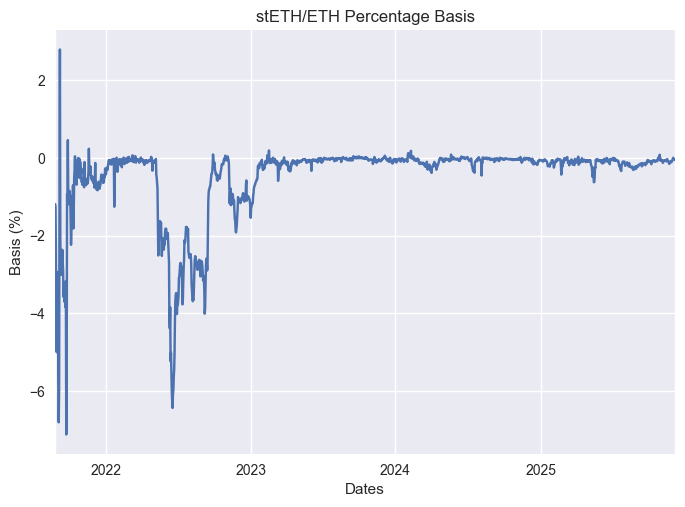

In [37]:
df.basis_pct.plot(xlabel='Dates', ylabel='Basis (%)', title='stETH/ETH Percentage Basis')

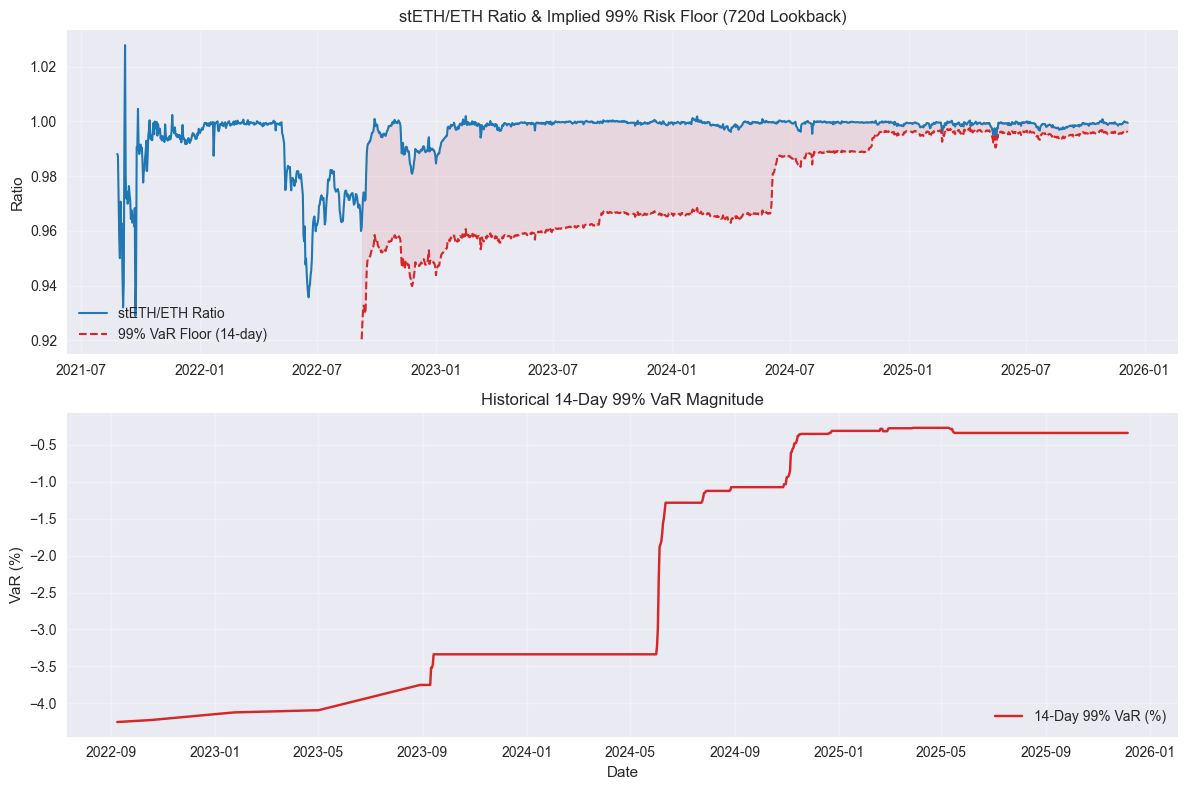

In [43]:
df['ratio_ret_14d'] = df['basis_ratio'].pct_change(14)

df['var_99_14d_pct'] = df['ratio_ret_14d'].rolling(window=720, min_periods=365).quantile(0.01)

df['ratio_var_floor'] = df['basis_ratio'] * (1 + df['var_99_14d_pct'])

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['basis_ratio'], label='stETH/ETH Ratio', color='#1f77b4', linewidth=1.5)
plt.plot(df.index, df['ratio_var_floor'], label='99% VaR Floor (14-day)', color='#d62728', linestyle='--', linewidth=1.5)
plt.fill_between(df.index, df['ratio_var_floor'], df['basis_ratio'], color='#d62728', alpha=0.1)
plt.title('stETH/ETH Ratio & Implied 99% Risk Floor (720d Lookback)')
plt.ylabel('Ratio')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df.index, df['var_99_14d_pct'] * 100, color='#d62728', label='14-Day 99% VaR (%)')
plt.title('Historical 14-Day 99% VaR Magnitude')
plt.ylabel('VaR (%)')
plt.xlabel('Date')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()